In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import pygad as ga
from tqdm import tqdm 
plt.style.use('ggplot')

### MPC with GA 
* model: x_{t+1} = x_t + sell ? p_i * q_i : 0 
* cost: maximize returns 
* optim: genetic algorithm over sequence of actions
* Action: sequence of p_storage + sequence of sell signals



In [8]:
N = 200 
dt = 5

make_sine = lambda t,f,m : ((np.sin(t * f) + 1)*0.5) * m

# Several sine components for production 
prod_magn_0 = 0.5
prod_freq_0 = 1.4
prod_magn_1 = 0.1
prod_freq_1 = 6.7
prod_magn_2 = 0.7
prod_freq_2 = 0.5



# Several sine components for price
prod_noise_magn = 0.01
price_magn_0 = 40
price_freq_0 = 1.7
price_magn_1 = 80
price_freq_1 = 0.4

price_offset = 50
price_noise_magn = 2

# Time horizon 
x = np.linspace(-np.pi * dt*0.5, np.pi * dt*0.5, N)


# Production values
production = make_sine(x,prod_freq_0, prod_magn_0) + \
             make_sine(x,prod_freq_1, prod_magn_1) + \
             make_sine(x,prod_freq_2, prod_magn_2)

production += np.random.normal(0,prod_noise_magn, size = production.shape)
production = np.where(production > 0, production, 0)

# Price values
price = make_sine(x,price_freq_0, price_magn_0) + \
        make_sine(x,price_freq_1, price_magn_1) + \
        price_offset#((np.sin(x * price_freq) + price_offset)*0.5) * price_magn
price += np.random.normal(0,price_noise_magn, size = price.shape)


data = pd.DataFrame(np.hstack([production.reshape(-1,1), price.reshape(-1,1)]), columns = 'prod,price'.split(','))
data.head()

,prod,price
0,1.117153,93.797788
1,1.088910,95.754790
2,1.082786,96.130991
3,1.073262,95.066605
4,1.060796,102.217274


Text(0.5, 1.0, 'Price')

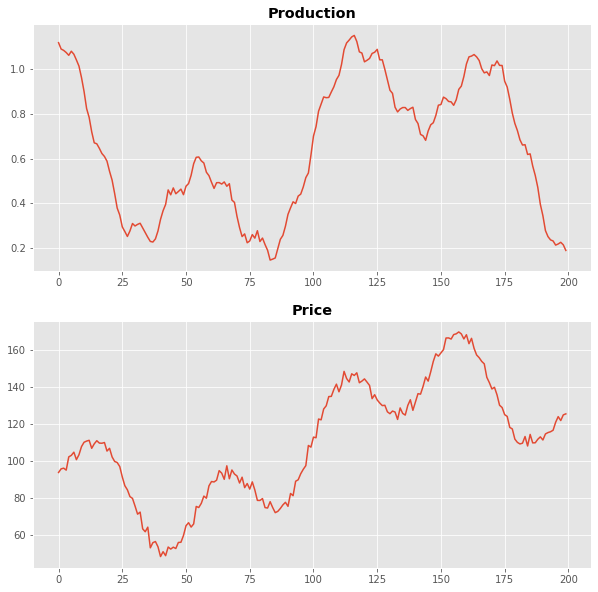

In [9]:
f, axes = plt.subplots(2,1, figsize = (10,10))
axes[0].plot(data['prod'])
axes[0].set_title('Production', weight = 'bold')
axes[1].plot(data['price'])
axes[1].set_title('Price', weight = 'bold')

In [36]:

# Simulation model: Should later be replaced by FMU
def sim_model(soc, current_prod, p_storage_i, do_sell, max_soc, efficiency = 0.7): 
    next_soc = np.clip(soc + current_prod * p_storage_i * efficiency,0.,1.)
    
    qty_to_sell  = 0. 
    if do_sell == 1 and next_soc / soc_max > 0.1:
        qty_to_sell = next_soc - max_soc * 0.1 # Battery returns to 10% of max load
        next_soc -= qty_to_sell 
        
    qty_to_sell += current_prod * (1. - p_storage_i)
    return next_soc, qty_to_sell 


# Cost function for GA
def compute_fitness(sol, sol_idx): 
    #print('Proposed sol {}\nClamped sol: {}'.format(sol, np.clip(sol, 0.,1.)))
    sol = np.clip(sol, 0.,1.)
    sol_pstorage = sol[:horizon]
    sol_sell = sol[horizon:]
    
    #print(p_storage)
    #print(sol_sell)
    
    #global soc
    #global data_idx
    #global indiv_0_scores 
    #global indiv_0_trajs
    #global record_0
    #global horizon
    
    indiv_soc = soc
    effective_returns = 0. 
    indiv_soc_recap = [indiv_soc]
    for i,(ps, sell) in enumerate(zip(sol_pstorage, sol_sell)): 
               
        indiv_soc, qty_to_sell = sim_model(indiv_soc, data['prod'][data_idx + i], ps, sell, soc_max)
        effective_returns += qty_to_sell * data['price'][data_idx + i]
        indiv_soc_recap.append(indiv_soc)

    
    potential_returns = soc * data['price'][data_idx + i + 1]
    #print('Indiv {} recap: \n{}\nScore:{}\n\n'.format(sol_idx,
    #                                                  indiv_soc_recap, 
    #                                                  effective_returns + potential_returns))    
    
    if sol_idx == 0: 
        if record_0:
            indiv_0_scores.append(effective_returns + potential_returns)
            indiv_0_trajs.append(sol)
    
    return effective_returns + potential_returns  

In [79]:
def get_action(**kwargs): 
    if kwargs['strategy'] == 'random': 
        return np.random.uniform(0.,1.), np.random.randint(0,2)
    elif kwargs['strategy'] == 'ga':

        params = {"num_generations" : kwargs['num_generations'] ,
                "num_parents_mating" : 4,
                "fitness_func" : compute_fitness,
                "sol_per_pop" : kwargs['sol_per_pop'],
                "num_genes" : kwargs['horizon'] * 2,
                "gene_type": [float for i in range(kwargs['horizon'])] + [int for i in range(kwargs['horizon'])],
                "init_range_low" : 0.,
                "init_range_high" : 2.,
                "parent_selection_type" : "sss",
                "keep_parents" : 1,
                "crossover_type" : "single_point",
                "mutation_type" : "random",
                "mutation_percent_genes" : 10}

        org = ga.GA(**params)
        org.run()
        solution, sol_fitness, sol_idx = org.best_solution()
        solution = np.clip(solution, 0., 1.)
        #print('\n\nBest solution\nID {}\nScore:{} \nSol:{}\n\n\n'.format(sol_idx, sol_fitness, solution))
        return solution[0], solution[horizon]
        


In [82]:
def show_results(records): 
    f, axes = plt.subplots(2,1, figsize = (15,12))
    axes = axes.flatten()
    
    if isinstance(records, pd.DataFrame):
        records = [records] # Only to cover multiple records case 
        
    for i, record in enumerate(records): 
        axes[0].plot(record.SOC/soc_max, label = 'SOC/SoC_MAX - Case {}'.format(i))
        axes[0].plot(record.StorageControl, label = 'P_Storage - Case {}'.format(i), alpha= 0.5)
        sell_flags = record[record.SellOrder == 1].SellOrder

        axes[0].scatter(sell_flags.index, 0.5 * np.ones((sell_flags.shape[0])), 
                       alpha = 0.5, label = 'Sell order - Case {}'.format(i), marker = '*')

        axes[1].plot(record.Equity, label = 'Individual {}'.format(i))
        axes[1].plot(record.Equity.cumsum(), label = 'Cumulative {}'.format(i))
        
    axes[0].set_ylim(0.,1.)
    axes[0].set_title('SoC', weight = 'bold')
    axes[1].legend()
    axes[0].set_title('SoC and Storage', weight = 'bold')
    axes[0].legend()

In [85]:
def run_sim(sim_params): 
    
    global horizon 
    global soc
    global data_idx
    global soc_max
    global record_0 
    global indiv_0_scores
    global indiv_0_trajs
    
    horizon = sim_params['horizon']
    soc = sim_params['current_soc']
    soc_max = sim_params['soc_max']
    equity = sim_params['initial_capital']
    
    indiv_0_scores = []
    indiv_0_trajs = []
    record_0 = True
    
    record_cols = ['SOC', 'Equity', 'StorageControl', 'SellOrder'] 
    records = pd.DataFrame(data = [[soc/soc_max, equity, 0.,0.]], columns = record_cols)

    pbar = tqdm(total = sim_params['run_for'])
    for data_idx in range(sim_params['run_for']):
        #print('*'*10 + '\n' + 'STEP: {}'.format(data_idx))
        p_storage, do_sell = get_action(**sim_params)
        #print('*'*10 + 'P_Storage: {}'.format(p_storage) + '*'*10)
        soc, qty_to_sell = sim_model(soc, data['prod'][data_idx], p_storage, do_sell, soc_max)
        #print('SOC: {}'.format(soc))

        sale_return = qty_to_sell * data.price[data_idx]
        records = records.append(pd.DataFrame([[soc,
                                                sale_return,
                                                p_storage, 
                                                do_sell]], columns = record_cols))
        record_0 = False
        pbar.update(1)
    pbar.close()
    records.reset_index(drop = True, inplace = True)
    return records, [indiv_0_scores, indiv_0_trajs]


sim_params = {'strategy': 'ga', 
             'horizon': 15, 
             'current_soc': 0., 
             'soc_max': 2., 
             'initial_capital':0., 
             'num_generations':4,
             'sol_per_pop': 6, 
             'run_for': 100}

records, indiv_0_data = run_sim(sim_params)
sim_params['num_generations'] = 10
sim_params['sol_per_pop'] = 100
sim_params['horizon'] = 50
records_1, indiv_0_data = run_sim(sim_params)


100%|██████████| 100/100 [00:02<00:00, 45.69it/s][A

100%|██████████| 100/100 [02:57<00:00,  1.77s/it]


In [86]:
sim_params['strategy'] = 'random'
records_random, _ = run_sim(sim_params)


100%|██████████| 100/100 [00:00<00:00, 952.35it/s][A


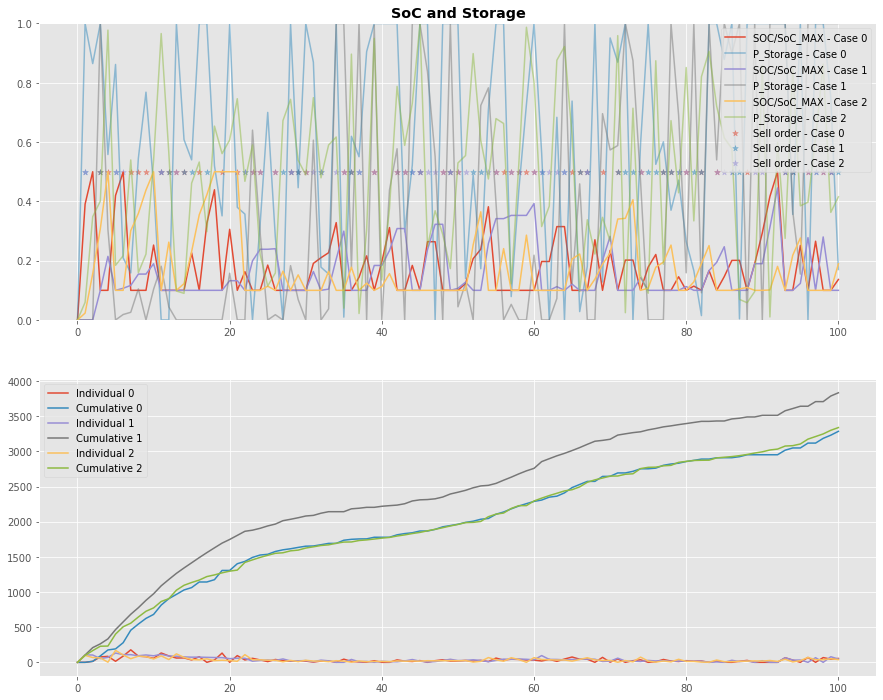

In [87]:
show_results([records, records_1, records_random])

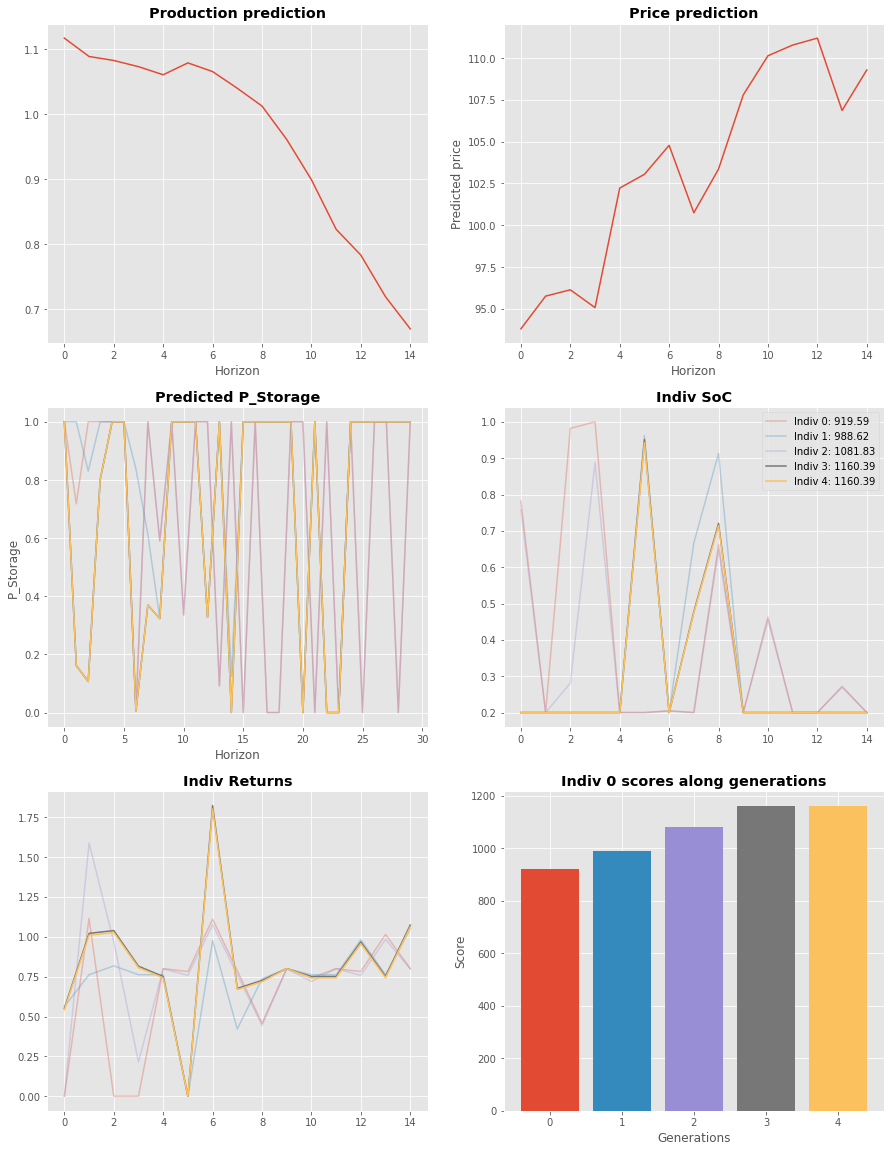

In [44]:
show_indiv_0()

In [70]:
horizon = 15
soc = 0. 
soc_max = 2. #MW (?)
equity = 0. 

indiv_0_scores = []
indiv_0_trajs = []
record_0 = True

sim_params = {'strategy': 'ga', 
             'horizon': horizon, 
             'current_soc': soc, 
             'soc_max': soc_max}

record_cols = ['SOC', 'Equity', 'StorageControl', 'SellOrder'] 
records = pd.DataFrame(data = [[soc/soc_max, equity, 0.,0.]], columns = record_cols)

pbar = tqdm(total = data.shape[0] - (horizon +1))
for data_idx in range(data.shape[0] - (horizon + 1)):
    #print('*'*10 + '\n' + 'STEP: {}'.format(data_idx))
    p_storage, do_sell = get_action(**sim_params)
    #print('*'*10 + 'P_Storage: {}'.format(p_storage) + '*'*10)
    soc, qty_to_sell = sim_model(soc, data['prod'][data_idx], p_storage, do_sell, soc_max)
    #print('SOC: {}'.format(soc))
    
    sale_return = qty_to_sell * data.price[data_idx]
    records = records.append(pd.DataFrame([[soc,
                                            sale_return,
                                            p_storage, 
                                            do_sell]], columns = record_cols))
    record_0= False
    pbar.update(1)
pbar.close()
records.reset_index(drop = True, inplace = True)

100%|██████████| 184/184 [00:04<00:00, 44.75it/s]


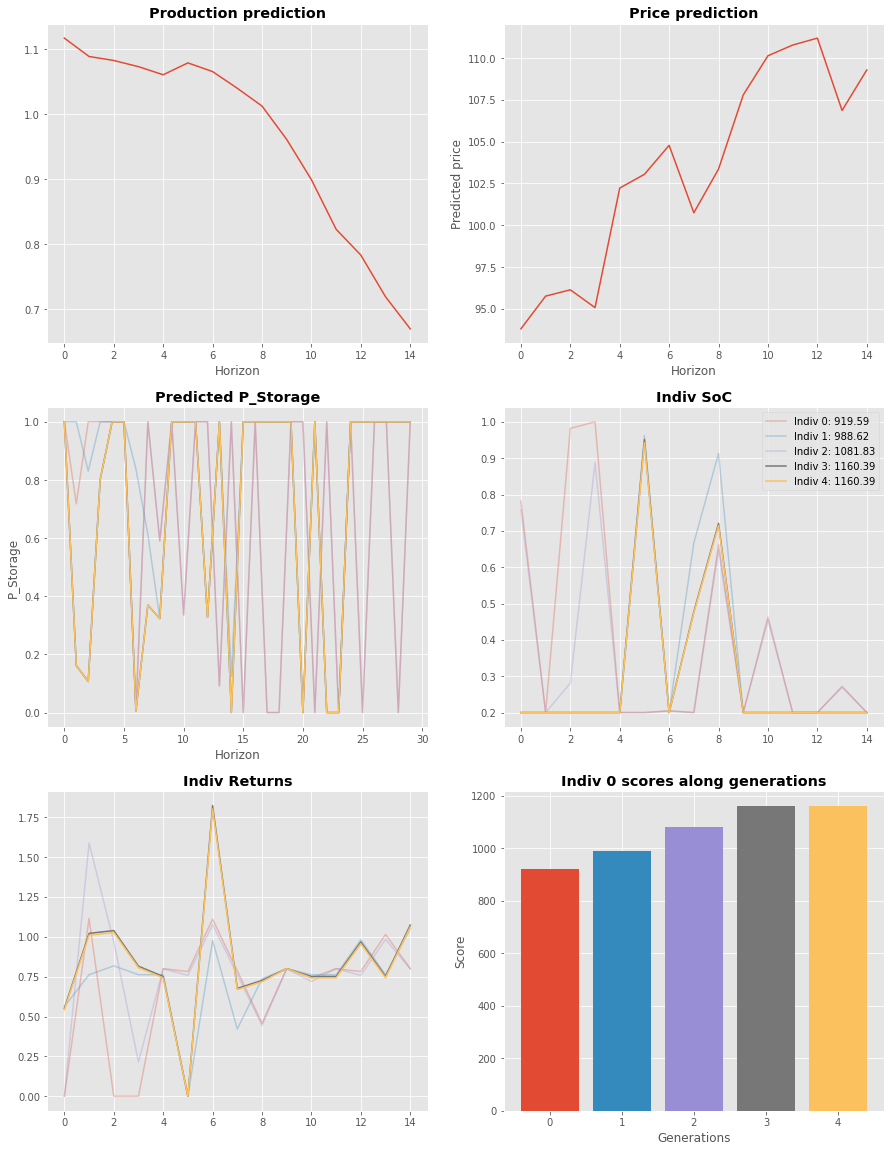

In [43]:
def show_indiv_0(start_idx = 0): 
    
    
    f, axes = plt.subplots(3,2, figsize = (15,20))
    axes = axes.flatten()
    axes[0].plot(data['prod'][start_idx:start_idx + horizon])
    axes[0].set_title('Production prediction', weight = 'bold')
    axes[0].set_xlabel('Horizon')
    axes[1].set_ylabel('Predicted production')
    axes[1].plot(data['price'][start_idx: start_idx + horizon])
    axes[1].set_title('Price prediction', weight = 'bold')
    axes[1].set_xlabel('Horizon')
    axes[1].set_ylabel('Predicted price')
    
    
    
    for i,(s,t) in enumerate(zip(indiv_0_scores, indiv_0_trajs)): 
        axes[-1].bar(i,height = s)
        axes[2].plot(t, label = 'Indiv {}: {:.2f}'.format(i, s), 
                    alpha = 1. if s == np.max(indiv_0_scores) else 0.3)
        
        indiv_soc_recap = []
        indiv_soc = 0
        indiv_returns_recap = []
        indiv_returns = 0
        t_storage = t[:horizon]
        t_sell = t[horizon:]
        
        for (tsel, tsto) in zip(t_sell, t_storage): 
            indiv_soc, indiv_returns = sim_model(indiv_soc, data['prod'][start_idx + i], tsto, tsel, soc_max)
            indiv_soc_recap.append(indiv_soc)
            indiv_returns_recap.append(indiv_returns)
        axes[3].plot(indiv_soc_recap,label = 'Indiv {}: {:.2f}'.format(i, s), 
                    alpha = 1. if s == np.max(indiv_0_scores) else 0.3)
        axes[4].plot(indiv_returns_recap, label = 'Indiv {}: {:.2f}'.format(i, s), 
                    alpha = 1. if s == np.max(indiv_0_scores) else 0.3)
        
    axes[3].set_title('Indiv SoC', weight = 'bold')
    axes[4].set_title('Indiv Returns', weight = 'bold')
    axes[3].legend()
    axes[2].set_title('Predicted P_Storage', weight = 'bold')
    axes[2].set_xlabel('Horizon')
    axes[2].set_ylabel('P_Storage')
    axes[-1].set_title('Indiv 0 scores along generations', weight = 'bold')
    axes[-1].set_xlabel('Generations')
    axes[-1].set_ylabel('Score')
    
    
    

show_indiv_0()

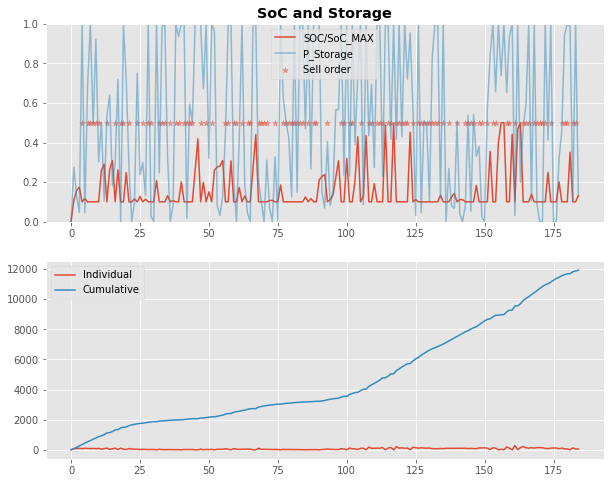

In [69]:
show_results(records)